<a href="https://colab.research.google.com/github/jhkang0516/dialect_classification/blob/main/ResNeXt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/TeamProject/'

/content/drive/MyDrive/Colab Notebooks/TeamProject


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
import os
import math
import json
import random

In [ ]:
dataDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/"

In [ ]:
X_mfcc_ALL= np.load(dataDir + "X_mfcc_ALL.npy")
Y_label_ALL = np.load(dataDir + "Y_label_ALL.npy")

In [ ]:
print(X_mfcc_ALL.shape)
print(Y_label_ALL.shape)

(60000, 39, 259)
(60000,)


# 데이터 전처리

In [ ]:
# 필요한 라이브러리 설치
!pip install torch torchvision

# 라이브러리 불러오기
import torch
from torch.utils.data import TensorDataset
from torchvision.models import resnext50_32x4d
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# 레이블 인코더 생성
le = LabelEncoder()

# Y_label_ALL을 정수로 변환
Y_label_ALL = le.fit_transform(Y_label_ALL)


Y_label_ALL = torch.from_numpy(Y_label_ALL).long()


In [ ]:
# 채널 차원 추가
X_mfcc_ALL = np.expand_dims(X_mfcc_ALL, axis=1)

print(X_mfcc_ALL.shape)


(60000, 1, 39, 259)


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset 정의
class MFCCDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [ ]:

# 데이터를 훈련 세트와 검증 세트로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X_mfcc_ALL, Y_label_ALL, test_size=0.3, random_state=42, stratify=Y_label_ALL)

# 훈련 세트와 검증 세트를 PyTorch Tensor로 변환
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).long()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).long()

# 훈련 세트와 검증 세트를 PyTorch Dataset으로 변환
train_dataset = MFCCDataset(X_train, Y_train)
test_dataset = MFCCDataset(X_test, Y_test)

# 훈련 세트와 검증 세트를 PyTorch DataLoader로 변환
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


<ipython-input-11-8470e05db20b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train).long()
<ipython-input-11-8470e05db20b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test).long()


In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnext50_32x4d(pretrained=False)

# 첫 번째 Convolutional 레이어를 수정
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 출력 레이어를 수정
num_classes = 6  # 총 6개 지역(클래스)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 모델을 GPU로 전송
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
import torch.optim as optim

# 손실 함수 및 최적화 알고리즘 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 학습 시작
for epoch in range(20):  # 20번의 에포크를 진행
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()

    for i, data in enumerate(train_dataloader):
        # 입력 데이터와 타깃 레이블을 GPU로 전송
        inputs, labels = data[0].to(device), data[1].to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # epoch마다 정확도와 손실 출력
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = 100 * correct / total
    print('Epoch [%d/%d] Loss: %.3f Accuracy: %.2f %%' % (epoch + 1, 20, epoch_loss, epoch_accuracy))

print('Finished Training')


Epoch [1/20] Loss: 0.023 Accuracy: 71.88 %
Epoch [2/20] Loss: 0.014 Accuracy: 81.92 %
Epoch [3/20] Loss: 0.013 Accuracy: 83.70 %
Epoch [4/20] Loss: 0.011 Accuracy: 85.88 %
Epoch [5/20] Loss: 0.011 Accuracy: 86.89 %
Epoch [6/20] Loss: 0.009 Accuracy: 88.78 %
Epoch [7/20] Loss: 0.008 Accuracy: 89.15 %
Epoch [8/20] Loss: 0.008 Accuracy: 90.57 %
Epoch [9/20] Loss: 0.007 Accuracy: 91.27 %
Epoch [10/20] Loss: 0.006 Accuracy: 92.63 %
Epoch [11/20] Loss: 0.005 Accuracy: 93.49 %
Epoch [12/20] Loss: 0.005 Accuracy: 93.83 %
Epoch [13/20] Loss: 0.004 Accuracy: 95.10 %
Epoch [14/20] Loss: 0.004 Accuracy: 95.67 %
Epoch [15/20] Loss: 0.003 Accuracy: 96.46 %
Epoch [16/20] Loss: 0.003 Accuracy: 96.75 %
Epoch [17/20] Loss: 0.002 Accuracy: 97.46 %
Epoch [18/20] Loss: 0.002 Accuracy: 97.30 %
Epoch [19/20] Loss: 0.002 Accuracy: 97.92 %
Epoch [20/20] Loss: 0.002 Accuracy: 97.97 %
Finished Training


In [ ]:
import torch.nn.functional as F

correct = 0
total = 0

# 모델을 평가 모드로 설정
model.eval()

predictions = []
targets = []


# 예측 결과와 실제 레이블 비교
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        # 예측 결과와 실제 타깃 정보 저장
        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

        # 예측된 클래스 레이블과 해당 클래스에 대한 예측 점수 출력
        for i in range(len(predicted)):
            predicted_label = predicted[i]
            predicted_score = probabilities[i][predicted_label]
            print("Predicted Label: {}, Score: {:.4f}".format(predicted_label, predicted_score))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 정확도 계산
accuracy = 100 * correct / total
print('Accuracy: %.2f %%' % accuracy)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Predicted Label: 1, Score: 0.9847
Predicted Label: 3, Score: 1.0000
Predicted Label: 3, Score: 1.0000
Predicted Label: 1, Score: 1.0000
Predicted Label: 3, Score: 1.0000
Predicted Label: 3, Score: 1.0000
Predicted Label: 2, Score: 1.0000
Predicted Label: 5, Score: 1.0000
Predicted Label: 0, Score: 0.9996
Predicted Label: 1, Score: 0.9995
Predicted Label: 0, Score: 1.0000
Predicted Label: 0, Score: 0.9993
Predicted Label: 4, Score: 1.0000
Predicted Label: 0, Score: 1.0000
Predicted Label: 4, Score: 1.0000
Predicted Label: 3, Score: 1.0000
Predicted Label: 1, Score: 0.9984
Predicted Label: 3, Score: 0.9987
Predicted Label: 0, Score: 1.0000
Predicted Label: 1, Score: 1.0000
Predicted Label: 2, Score: 0.9834
Predicted Label: 3, Score: 1.0000
Predicted Label: 1, Score: 0.9962
Predicted Label: 4, Score: 1.0000
Predicted Label: 2, Score: 0.9925
Predicted Label: 3, Score: 1.0000
Predicted Label: 5, Score: 1.0000
Predicted Label: 1, Score: 0.9999
Predicted La

In [ ]:
# 클래스 레이블 정의
class_labels = ['GyeonSang', 'JeonLa', 'JeJu', 'ChungCheong', 'GangWon', 'Standard']  # 클래스 레이블에 해당하는 정보를 리스트로 정의


In [ ]:
from sklearn.metrics import classification_report

# 평가 지표 계산 및 출력
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

   GyeonSang       0.92      0.92      0.92      3000
      JeonLa       0.77      0.82      0.80      3000
        JeJu       0.80      0.78      0.79      3000
 ChungCheong       0.99      1.00      0.99      3000
     GangWon       0.94      0.92      0.93      3000
    Standard       1.00      0.99      0.99      3000

    accuracy                           0.90     18000
   macro avg       0.90      0.90      0.90     18000
weighted avg       0.90      0.90      0.90     18000



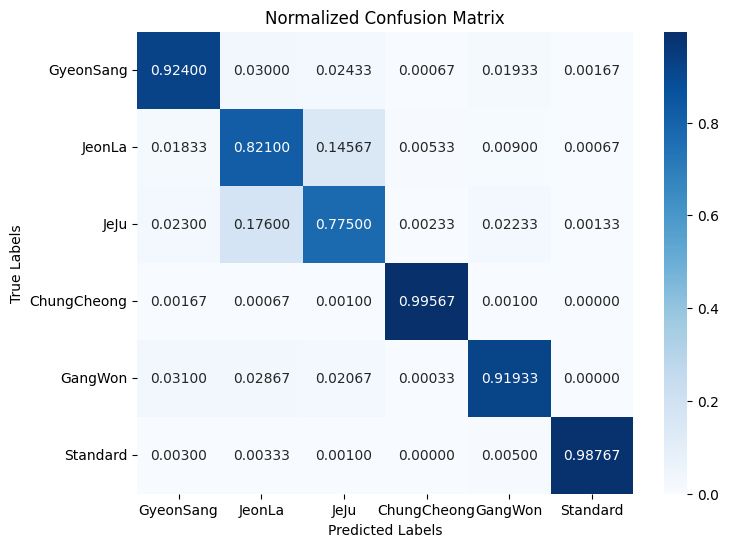

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    all_predicted = []
    all_labels = []
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)

        all_predicted.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 오차 행렬 계산
cm = confusion_matrix(all_labels, all_predicted)

# 오차 행렬을 0~1로 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 오차 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.5f', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()
